<a href="https://colab.research.google.com/github/MiladQolami/Neural-Data-Analysis/blob/main/SpikingVariablity/SpikingVariablity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭕ spiking variablity

---











#### In order to create a consistent percetion of sensory stimuli which is essential for consistent behavior, neurons should encode information in a reliable way. But studies show that spiking activity is highly variable. For example, whenever we present an identical stimulus and record neuronal activity the number of spikes (spike counts), the time interval between spikes (interspike interval) and structures in the spike train (for example burst or sparse) would be significantly variable. Possible source of this variablity might be current state of neuronal network, intrinsic neuroanl noise or properties or the neuron itself. In any case measuring spiking variablity can be an improtant setp toward understanding encoding infromation by neurons. 

#### In this notebook we explotre several common technique of measuring spiking variablity of spiking activity of neurons. In order to make our analysis more meaninful and goal oriented we propose a research question:

 ####  ▶   **Is there a relationship between different measures of spiking variblity and behavioral measures such as response time**?





### Dataset:
The data for this notebook comes from recording form mouse brain by a Neuropixel probes while doing a visual discremination task.
For more information see the paper [Steinmetz et.all, 2019](https://www.nature.com/articles/s41586-019-1787-x).

Here we pick spiking response of some units in the primary visual cortex.


In [1]:
# @markdown Import libraries

# Import pachages
import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

plt.rcParams['figure.figsize'] = [20,5]
plt.rcParams['font.size'] = 15
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [2]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
# @title Data loading
all_data = np.array([])
for j in range(len(fname)):
  all_data = np.hstack((all_data,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
data = all_data[11] # We only choose session 11 for our analysis, according to author this session has several units in visual cortex

The whole dataset contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. We have picked just one session (session 11) and stored it in `data`, which is a dictionary with several fields. You can find them using the method `.keys()`. Some of them are as below:


* `data['spks']`: neurons by trials by time bins.    
* `data['brain_area']`: brain area for each neuron recorded. 
* `data['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `data['contrast_left']`: contrast level for left stimulus. 
* `data['gocue']`: when the go cue sound was played. 
* `data['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `data['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `data['feedback_time']`: when feedback was provided. 
* `data['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `data['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `data['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.

* `data['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  



#### **First of all data exploration and visualization**

In [4]:
# Run the codes line by line
data.keys()         # All fields

all_brain_areas = data['brain_area']
type(all_brain_areas)                     # What is iside each field
all_brain_areas.shape                     # What is the shape of it

all_spikes = data['spks']
type(all_spikes)
all_spikes.shape


(698, 340, 250)

<ipython-input-7-3e3d0bc43410>:4: DeprecationWarning: This function is deprecated. Please call randint(1, 698 + 1) instead
  random_neuron = np.random.random_integers(neuron_n)     # Pick a random neuron


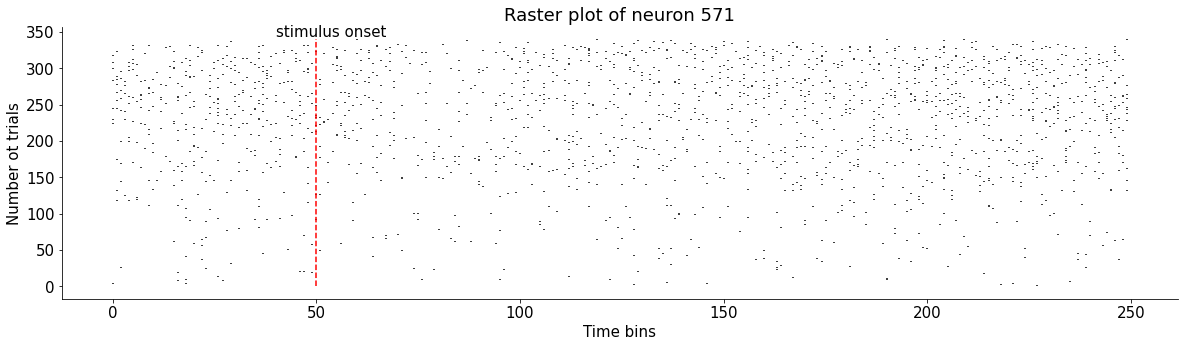

In [7]:
# @markdown Run this cell several times to see raster plot of different neuron in this session
# Raster plot of random neuron 
neuron_n = data['spks'].shape[0]        # Number of neuron in this plot
random_neuron = np.random.random_integers(neuron_n)     # Pick a random neuron
fig, ax = plt.subplots()
for trial_i in range(data['spks'][random_neuron].shape[0]):
  ax.vlines(np.argwhere(data['spks'][random_neuron][trial_i,:]),trial_i,trial_i +1)
ax.vlines(50,0,data['spks'][random_neuron].shape[0],linestyles='dashed',color = 'red')
ax.set(xlabel = 'Time bins', ylabel = "Number ot trials",title=f'Raster plot of neuron {random_neuron}')
plt.text(50 - 10,trial_i+5,'stimulus onset')
plt.show()


In [8]:
visual_cortex = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]  # visual cortex
hippocampus =  ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal

In [38]:
idx_vis = np.isin(data['brain_area'],visual_cortex)   # Indices for neurons(units) in visual cortex regions
neuron_vis = idx_vis.sum()                            # How many visual neuron we have in this particular session
spikes_vis = data['spks'][idx_vis]                    # All spikes of visual neurns
trial_n = data['spks'].shape[1]
time_bins = np.arange(0,250,1)

#### Population response of visual neurons

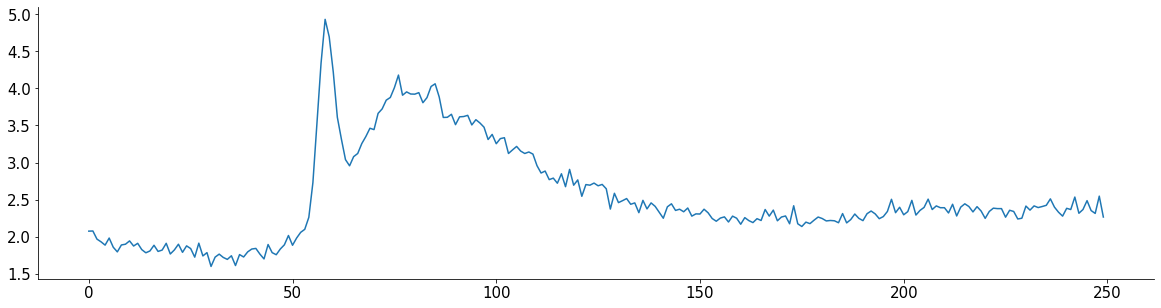

In [39]:
average_resp_vis = np.mean(np.mean(spikes_vis,0),0) * 100

fig,ax = plt.subplots()
ax.plot(time_bins,average_resp_vis)
plt.show()

In [ ]:
# @markdown Add standard error of mean 
SEM_resp_vis = np.std(np.mean(spikes_vis,0),0) / np.sqrt(trial_n)
fig,ax = plt.subplots()
ax.plot(time_bins,average_resp_vis,linewidth = 2)
ax.fill_between(time_bins,average_resp_vis - SEM_resp_vis,average_resp_vis + SEM_resp_vis,alpha = .5)
plt.show()

#### It is obvious that between time bins 50 and 100, average firing rate or number of spikes has increased significantly so it would be a good idea to compute spike count in this period for each trial and see if there is a correlation between spike count and response time.

#### But before that, we need to do basline subtraction. But why and how? 

#### As you previously obseerved we have 145 neurons in visual regions and each neuron fires significantly different number of spoikes during each trial but this difference is not solely due to presentation of the stimulus. In fact some neurons fire more compared to others even when they are not evoked by presenting stimulus and it is becuase their baseline activity is higher, so in order to extract neural activity evoked by presentation of the stimulus we need to subtract baseline activity from the overall activity to get the evoked response.

#### Here we have 500 ms of baseline activity before presentation of the stimulus. We take avrage during this period and subtract from the whole trial.

#### To do that we use nice properties of elementwise subtraction of numpy arrays where we just need to take care of dimesions and and mumpy features will take care of rest of it.

<br>
<p align='center'>
<img scr = "https://github.com/MiladQolami/Neural-Data-Analysis/blob/main/images/Numpby%20array%20row%20subtraction.jpg?raw=1" width="600" height="300">




In [40]:
spikes_vis_base_sub = spikes_vis[:,:,:] - np.mean(spikes_vis[:,:,0:50],2,keepdims=True)    # Baseline subtracted data


#### Let's plot the population response again. Note that the shape of the cureve should not change, just the scale on the y-axis.

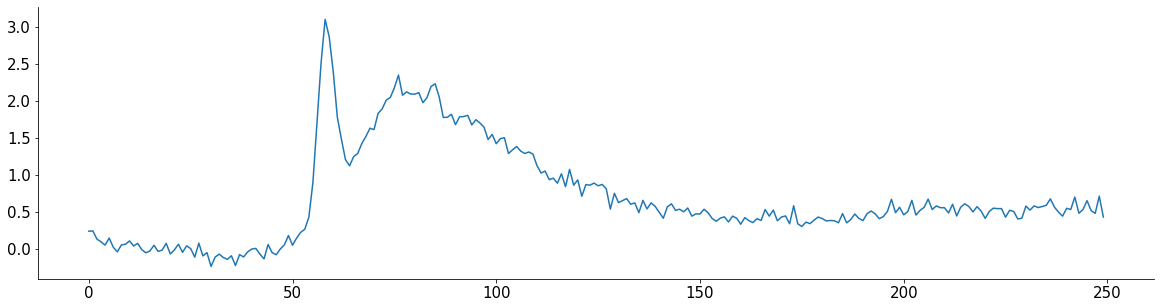

In [41]:
average_resp_vis = np.mean(np.mean(spikes_vis_base_sub,0),0) * 100

fig,ax = plt.subplots()
ax.plot(time_bins,average_resp_vis)
plt.show()

## Spike count corelation
#### One of the most important aspects of spiking activity is spike count. It has been suggested that spike count encodes identity of the stimuli. But here we want to investigate the relationship between spike count and response time.

## Irigularity of inter-spike-interval (ISI)


## Trial-to-tiral variablity



